# NFL Playoff Prediction with Feedforward Neural Network

##### By: Mike Meissner
##### May 22nd, 2024
##### Machine Learning Final Project

## Imports/Data Loading & Preparation

In [172]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', None)

In [9]:
directory = r'/Users/mikemeissner/Library/CloudStorage/OneDrive-TheUniversityofChicago/NFL_Project'

yearly_data = {}

for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        file_path = os.path.join(directory, filename)
        
        parts = filename.replace('.csv', '').split('_')
        stat_type = parts[0]  
        year = parts[1]
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:-3]  
        df['Year'] = year  
        
        if year not in yearly_data:
            yearly_data[year] = {}
        
        yearly_data[year][stat_type] = df

combined_years = []
for year, data in yearly_data.items():
    if 'offense' in data and 'defense' in data:
        combined_df = pd.merge(data['offense'], data['defense'], on=['Tm', 'Year'], suffixes=('_off', '_def'))
        combined_years.append(combined_df)

final_df = pd.concat(combined_years, ignore_index=True)

print(final_df.head())

   Rk_off                    Tm  G_off     PF  Yds_off  Ply_off  Y/P_off  \
0     1.0     Green Bay Packers   16.0  509.0   6224.0    990.0      6.3   
1     2.0         Buffalo Bills   16.0  501.0   6343.0   1034.0      6.1   
2     3.0  Tampa Bay Buccaneers   16.0  492.0   6145.0   1017.0      6.0   
3     4.0      Tennessee Titans   16.0  491.0   6343.0   1031.0      6.2   
4     5.0    New Orleans Saints   16.0  482.0   6023.0   1045.0      5.8   

   TO_off  FL_off  1stD_off  Cmp_off  Att_off  Yds.1_off  TD_off  Int_off  \
0    11.0     6.0     358.0    372.0    526.0     4106.0    48.0      5.0   
1    22.0    11.0     397.0    410.0    596.0     4620.0    40.0     11.0   
2    17.0     5.0     364.0    410.0    626.0     4626.0    42.0     12.0   
3    12.0     5.0     381.0    316.0    485.0     3653.0    33.0      7.0   
4    17.0     9.0     367.0    370.0    522.0     3758.0    28.0      8.0   

   NY/A_off  1stD.1_off  Att.1_off  Yds.2_off  TD.1_off  Y/A_off  1stD.2_off  \


In [10]:
final_df

,Rk_off,Tm,G_off,PF,Yds_off,Ply_off,Y/P_off,TO_off,FL_off,1stD_off,Cmp_off,Att_off,Yds.1_off,TD_off,Int_off,NY/A_off,1stD.1_off,Att.1_off,Yds.2_off,TD.1_off,Y/A_off,1stD.2_off,Pen_off,Yds.3_off,1stPy_off,Sc%_off,TO%_off,EXP_off,Year,Rk_def,G_def,PA,Yds_def,Ply_def,Y/P_def,TO_def,FL_def,1stD_def,Cmp_def,Att_def,Yds.1_def,TD_def,Int_def,NY/A_def,1stD.1_def,Att.1_def,Yds.2_def,TD.1_def,Y/A_def,1stD.2_def,Pen_def,Yds.3_def,1stPy_def,Sc%_def,TO%_def,EXP_def
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,372.0,526.0,4106.0,48.0,5.0,7.5,216.0,443.0,2118.0,16.0,4.8,114.0,84.0,684.0,28.0,49.7,5.6,290.75,2020,13.0,16.0,369.0,5344.0,974.0,5.5,18.0,7.0,332.0,346.0,536.0,3539.0,23.0,11.0,6.1,184.0,397.0,1805.0,16.0,4.5,119.0,79.0,734.0,29.0,39.9,11.4,-109.67
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,410.0,596.0,4620.0,40.0,11.0,7.4,240.0,411.0,1723.0,16.0,4.2,119.0,102.0,941.0,38.0,49.4,11.8,228.66,2020,16.0,16.0,375.0,5640.0,1025.0,5.5,26.0,11.0,351.0,369.0,573.0,3726.0,23.0,15.0,6.1,199.0,414.0,1914.0,21.0,4.6,125.0,86.0,728.0,27.0,39.4,15.3,-123.10
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,410.0,626.0,4626.0,42.0,12.0,7.1,238.0,369.0,1519.0,16.0,4.1,82.0,84.0,715.0,44.0,47.8,8.9,246.24,2020,8.0,16.0,355.0,5234.0,1023.0,5.1,25.0,10.0,319.0,426.0,617.0,3945.0,29.0,15.0,5.9,215.0,358.0,1289.0,10.0,3.6,78.0,95.0,1015.0,26.0,33.7,14.0,-22.04
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,316.0,485.0,3653.0,33.0,7.0,7.2,203.0,521.0,2690.0,26.0,5.2,142.0,86.0,783.0,36.0,47.9,7.2,245.01,2020,24.0,16.0,439.0,6372.0,1076.0,5.9,23.0,8.0,391.0,423.0,630.0,4439.0,36.0,15.0,6.8,247.0,427.0,1933.0,18.0,4.5,113.0,103.0,840.0,31.0,45.2,13.3,-185.20
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,370.0,522.0,3758.0,28.0,8.0,6.8,199.0,494.0,2265.0,30.0,4.6,147.0,98.0,1005.0,21.0,45.5,9.0,176.94,2020,5.0,16.0,337.0,4974.0,992.0,5.0,26.0,8.0,320.0,333.0,557.0,3472.0,28.0,18.0,5.8,185.0,390.0,1502.0,11.0,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,28.0,Oakland Raiders,16.0,290.0,5379.0,995.0,5.4,24.0,14.0,300.0,382.0,556.0,3751.0,19.0,10.0,6.2,197.0,387.0,1628.0,9.0,4.2,86.0,110.0,965.0,17.0,31.3,13.6,-17.92,2018,32.0,16.0,467.0,6102.0,973.0,6.3,17.0,3.0,317.0,299.0,480.0,3853.0,36.0,14.0,7.8,178.0,480.0,2249.0,16.0,4.7,108.0,117.0,991.0,31.0,44.3,9.8,-172.07
188,29.0,Washington Redskins,16.0,281.0,4795.0,967.0,5.0,19.0,4.0,280.0,311.0,509.0,3021.0,16.0,15.0,5.5,156.0,414.0,1774.0,12.0,4.3,96.0,115.0,1008.0,28.0,31.8,11.2,-34.07,2018,15.0,16.0,359.0,5654.0,996.0,5.7,26.0,11.0,330.0,362.0,537.0,3794.0,27.0,15.0,6.5,197.0,413.0,1860.0,12.0,4.5,109.0,102.0,791.0,24.0,35.1,14.6,-87.52
189,30.0,Buffalo Bills,16.0,269.0,4778.0,1008.0,4.7,32.0,9.0,283.0,271.0,499.0,2794.0,13.0,23.0,5.2,137.0,468.0,1984.0,15.0,4.2,108.0,116.0,992.0,38.0,26.4,15.5,-104.81,2018,18.0,16.0,374.0,4706.0,968.0,4.9,27.0,11.0,293.0,313.0,492.0,2867.0,22.0,16.0,5.4,157.0,440.0,1839.0,17.0,4.2,111.0,99.0,976.0,25.0,33.3,14.3,20.12
190,31.0,Jacksonville Jaguars,16.0,245.0,4832.0,1005.0,4.8,29.0,16.0,277.0,329.0,536.0,3109.0,15.0,13.0,5.3,164.0,416.0,1723.0,7.0,4.1,92.0,121.0,1112.0,21.0,25.0,15.6,-98.17,2018,5.0,16.0,316.0,4983.0,970.0,5.1,17.0,6.0,288.0,312.0,499.0,3113.0,17.0,11.0,5.8,162.0,434.0,1870.0,16.0,4.3,89.0,92.0,735.0,37.0,33.1,8.3,4.66


In [11]:
years = range(2018, 2024)  
all_playoff_data = pd.DataFrame()

for year in years:
    url_nfc = f'https://www.pro-football-reference.com/years/{year}/playoffs.htm'
    url_afc = f'https://www.pro-football-reference.com/years/{year}/playoffs.htm'
    
    dfs_nfc = pd.read_html(url_nfc)
    dfs_afc = pd.read_html(url_afc)
    
    df_nfc = dfs_nfc[0]  
    df_afc = dfs_afc[1]  
    
    df_nfc['Year'] = year
    df_afc['Year'] = year
    df_year = pd.concat([df_nfc, df_afc], ignore_index=True)
    
    all_playoff_data = pd.concat([all_playoff_data, df_year], ignore_index=True)

In [12]:
all_playoff_data

,Seed,Tm,W,L,T,W-L%,SRS,Why,Reason,Year
0,1.0,New Orleans Saints,13,3,0,0.813,10.07,South Champion,head-to-head record over Los Angeles Rams,2018
1,2.0,Los Angeles Rams,13,3,0,0.813,8.49,West Champion,NaN,2018
2,3.0,Chicago Bears,12,4,0,0.750,6.28,North Champion,NaN,2018
3,4.0,Dallas Cowboys,10,6,0,0.625,1.09,East Champion,NaN,2018
4,5.0,Seattle Seahawks,10,6,0,0.625,4.51,Wild Card #1,NaN,2018
...,...,...,...,...,...,...,...,...,...,...
187,NaN,Denver Broncos,8,9,0,0.471,-3.80,NaN,NaN,2023
188,NaN,New York Jets,7,10,0,0.412,-5.76,NaN,NaN,2023
189,NaN,Tennessee Titans,6,11,0,0.353,-3.24,NaN,NaN,2023
190,NaN,Los Angeles Chargers,5,12,0,0.294,-2.19,NaN,NaN,2023


In [13]:
all_playoff_data = all_playoff_data.dropna(subset=['Seed'])
all_playoff_data

,Seed,Tm,W,L,T,W-L%,SRS,Why,Reason,Year
0,1.0,New Orleans Saints,13,3,0,0.813,10.07,South Champion,head-to-head record over Los Angeles Rams,2018
1,2.0,Los Angeles Rams,13,3,0,0.813,8.49,West Champion,NaN,2018
2,3.0,Chicago Bears,12,4,0,0.750,6.28,North Champion,NaN,2018
3,4.0,Dallas Cowboys,10,6,0,0.625,1.09,East Champion,NaN,2018
4,5.0,Seattle Seahawks,10,6,0,0.625,4.51,Wild Card #1,NaN,2018
...,...,...,...,...,...,...,...,...,...,...
178,3.0,Kansas City Chiefs,11,6,0,0.647,3.75,West Champion,NaN,2023
179,4.0,Houston Texans,10,7,0,0.588,0.43,South Champion,NaN,2023
180,5.0,Cleveland Browns,11,6,0,0.647,3.32,Wild Card #1,conference win percentage over Miami Dolphins,2023
181,6.0,Miami Dolphins,11,6,0,0.647,4.41,Wild Card #2,NaN,2023


In [14]:
all_playoff_data['Made_Playoffs'] = 1

/var/folders/59/tnjzcwgs4_91cbzw6yyg8r5r0000gn/T/ipykernel_27691/869606336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_playoff_data['Made_Playoffs'] = 1


In [15]:
final_df['Year'] = final_df['Year'].astype(int)

In [16]:
final_df = pd.merge(final_df, all_playoff_data[['Tm', 'Year', 'Made_Playoffs']],
                    left_on=['Tm', 'Year'], right_on=['Tm', 'Year'], how='left')
final_df['Made_Playoffs'].fillna(0, inplace=True)

In [19]:
final_df.to_csv('final_combined_data.csv', index=False)

## EDA and Feature Engineering

In [20]:
final_df.shape

(192, 57)

In [180]:
final_df.isnull().sum()

Rk_off             0
Tm                 0
G_off              0
PF                 0
Yds_off            0
                  ..
PPP_def            0
YPP_off            0
YPP_def            0
ODYR               0
TO_per_game_def    0
Length: 63, dtype: int64

In [21]:
final_df.describe()

,Rk_off,G_off,PF,Yds_off,Ply_off,Y/P_off,TO_off,FL_off,1stD_off,Cmp_off,Att_off,Yds.1_off,TD_off,Int_off,NY/A_off,1stD.1_off,Att.1_off,Yds.2_off,TD.1_off,Y/A_off,1stD.2_off,Pen_off,Yds.3_off,1stPy_off,Sc%_off,TO%_off,EXP_off,Year,Rk_def,G_def,PA,Yds_def,Ply_def,Y/P_def,TO_def,FL_def,1stD_def,Cmp_def,Att_def,Yds.1_def,TD_def,Int_def,NY/A_def,1stD.1_def,Att.1_def,Yds.2_def,TD.1_def,Y/A_def,1stD.2_def,Pen_def,Yds.3_def,1stPy_def,Sc%_def,TO%_def,EXP_def,Made_Playoffs
count,192.000000,192.000000,192.00000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.00000,192.000000,192.000000,192.000000,192.000000,192.000000,192.00000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,16.500000,16.489583,377.75000,5697.296875,1044.796875,5.453125,21.989583,8.906250,334.046875,365.015625,565.822917,3785.057292,25.307292,13.083333,6.256771,195.718750,439.166667,1912.239583,15.000000,4.333854,107.843750,99.62500,843.687500,30.484375,37.068750,11.533333,63.219427,2020.50000,16.500000,16.489583,377.750000,5697.296875,1044.796875,5.450521,21.989583,8.906250,334.046875,365.015625,565.822917,3785.057292,25.307292,13.083333,6.255729,195.718750,439.166667,1912.239583,15.000000,4.343229,107.843750,99.625000,843.687500,30.484375,36.998958,11.568229,-63.170260,0.416667
std,9.257232,0.501198,70.55153,590.122820,55.576045,0.496681,5.421491,2.905413,35.760004,46.104420,61.092753,571.043228,7.607130,4.326145,0.749070,29.775672,53.308677,356.664661,5.153152,0.431544,23.111081,13.95824,130.485907,6.401061,6.502441,2.760365,99.296569,1.71229,9.257232,0.501198,54.375946,504.312648,48.860367,0.400654,5.434030,2.898196,29.329379,33.205922,41.365437,414.576605,5.388989,4.155780,0.604666,21.432325,45.778929,307.595871,4.733749,0.411937,17.778349,12.570846,120.764043,6.686688,5.156778,2.816031,72.251295,0.494296
min,1.000000,16.000000,225.00000,3865.000000,878.000000,4.100000,8.000000,2.000000,239.000000,223.000000,377.000000,2219.000000,11.000000,4.000000,4.200000,109.000000,333.000000,1156.000000,3.000000,3.300000,61.000000,62.00000,534.000000,15.000000,19.300000,4.000000,-199.770000,2018.00000,1.000000,16.000000,225.000000,4414.000000,921.000000,4.600000,7.000000,2.000000,254.000000,297.000000,464.000000,2707.000000,12.000000,2.000000,4.700000,136.000000,332.000000,1181.000000,5.000000,3.300000,67.000000,64.000000,517.000000,15.000000,19.100000,3.900000,-283.040000,0.000000
25%,8.750000,16.000000,326.00000,5313.250000,1010.750000,5.100000,18.000000,7.000000,310.750000,336.750000,521.000000,3409.250000,19.000000,10.000000,5.700000,177.000000,399.750000,1649.750000,11.750000,4.100000,91.000000,89.00000,743.750000,26.000000,32.400000,9.600000,-10.505000,2019.00000,8.750000,16.000000,343.750000,5350.000000,1004.000000,5.200000,18.000000,7.000000,314.000000,341.750000,537.750000,3543.000000,21.000000,10.000000,5.900000,184.000000,408.750000,1748.750000,12.000000,4.100000,96.000000,91.000000,762.000000,25.000000,33.700000,9.400000,-113.117500,0.000000
50%,16.500000,16.000000,373.00000,5752.500000,1046.000000,5.450000,22.000000,9.000000,336.000000,364.000000,572.000000,3759.000000,25.000000,13.000000,6.200000,195.000000,434.000000,1887.500000,15.000000,4.300000,106.000000,100.00000,852.000000,30.000000,36.950000,11.300000,62.145000,2020.50000,16.500000,16.000000,371.000000,5677.500000,1043.000000,5.400000,22.000000,9.000000,332.500000,366.000000,562.000000,3801.500000,25.000000,13.000000,6.200000,196.000000,437.500000,1887.500000,14.500000,4.300000,107.500000,99.000000,831.000000,30.000000,36.800000,11.650000,-60.485000,0.000000
75%,24.250000,17.000000,428.00000,609

In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rk_off         192 non-null    float64
 1   Tm             192 non-null    object 
 2   G_off          192 non-null    float64
 3   PF             192 non-null    float64
 4   Yds_off        192 non-null    float64
 5   Ply_off        192 non-null    float64
 6   Y/P_off        192 non-null    float64
 7   TO_off         192 non-null    float64
 8   FL_off         192 non-null    float64
 9   1stD_off       192 non-null    float64
 10  Cmp_off        192 non-null    float64
 11  Att_off        192 non-null    float64
 12  Yds.1_off      192 non-null    float64
 13  TD_off         192 non-null    float64
 14  Int_off        192 non-null    float64
 15  NY/A_off       192 non-null    float64
 16  1stD.1_off     192 non-null    float64
 17  Att.1_off      192 non-null    float64
 18  Yds.2_off 

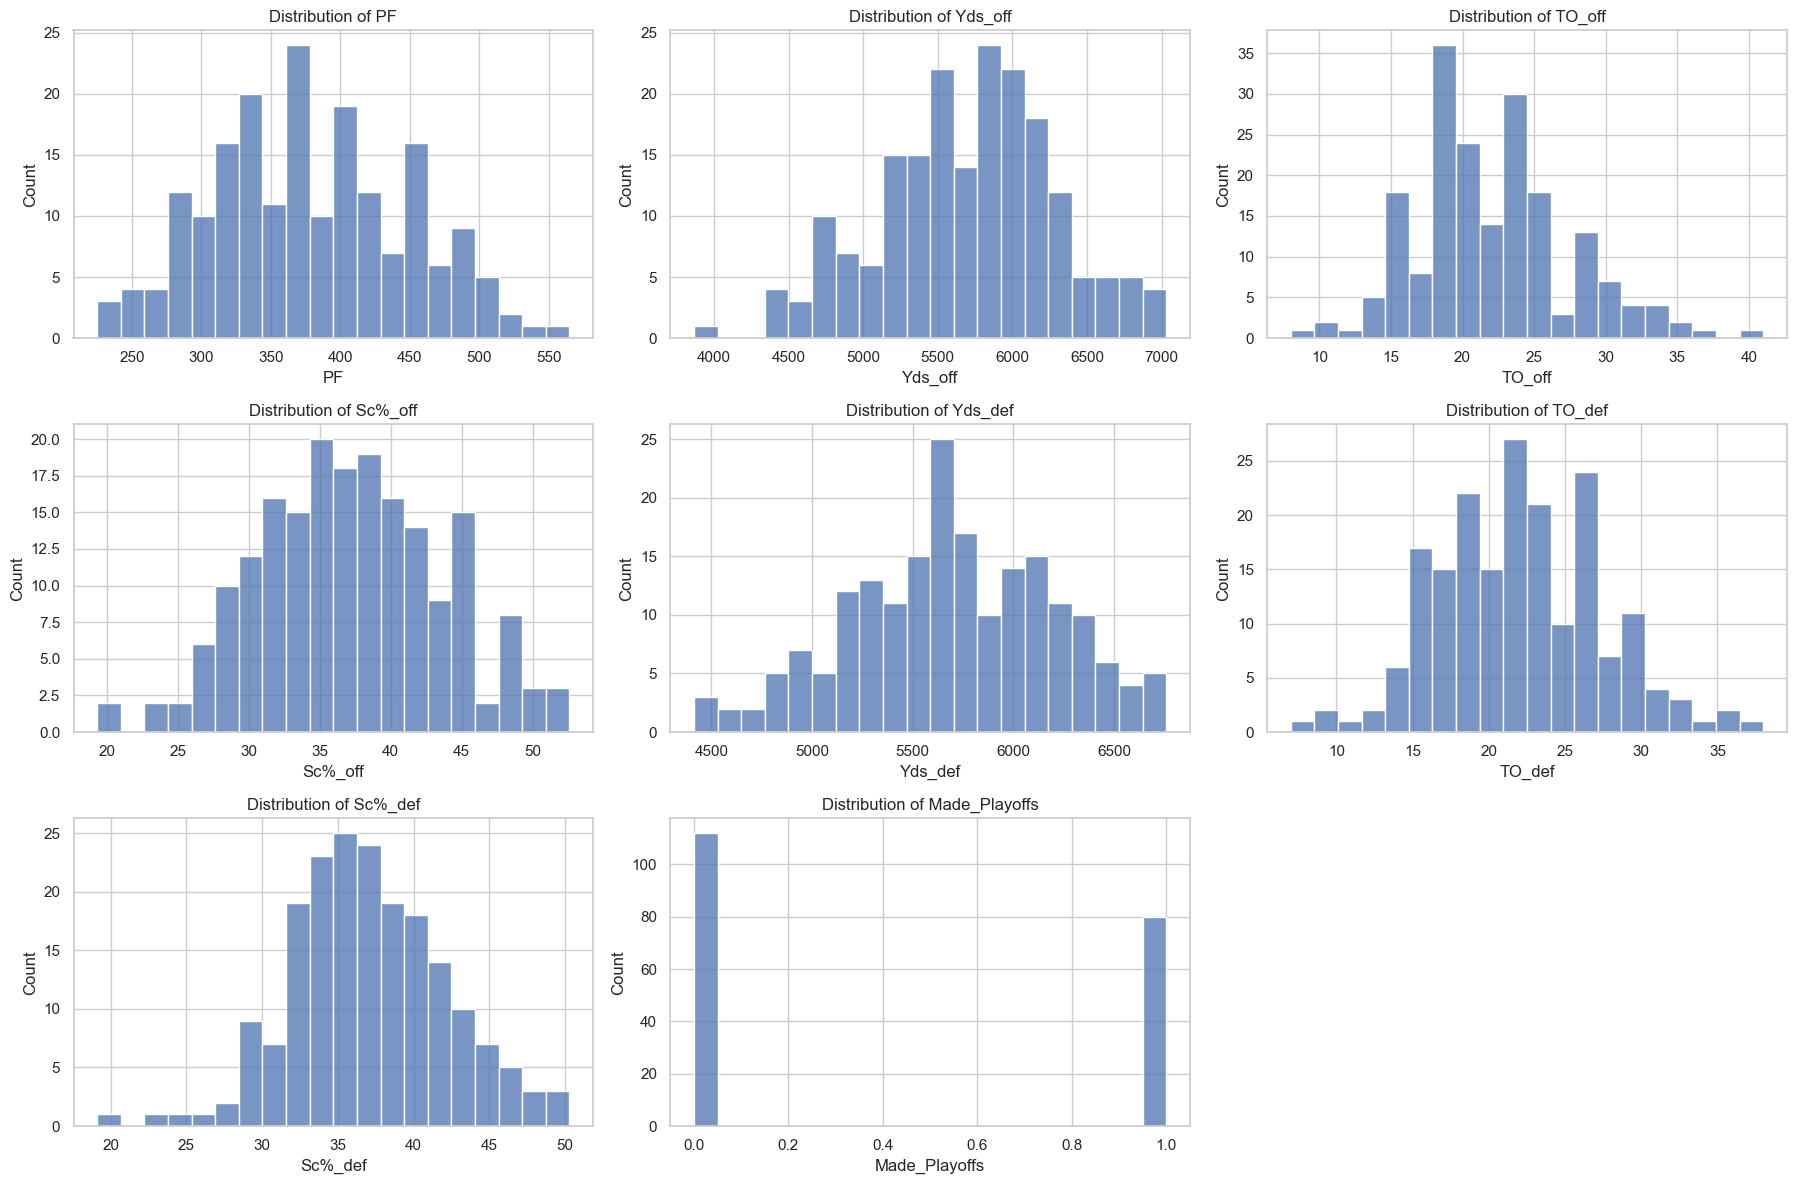

In [23]:
sns.set_theme(style="whitegrid")
columns_to_plot = ['PF', 'Yds_off', 'TO_off', 'Sc%_off', 'Yds_def', 'TO_def', 'Sc%_def', 'Made_Playoffs']

plt.figure(figsize=(18, 12))
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 3, i + 1)
    sns.histplot(final_df[column], kde=False, bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

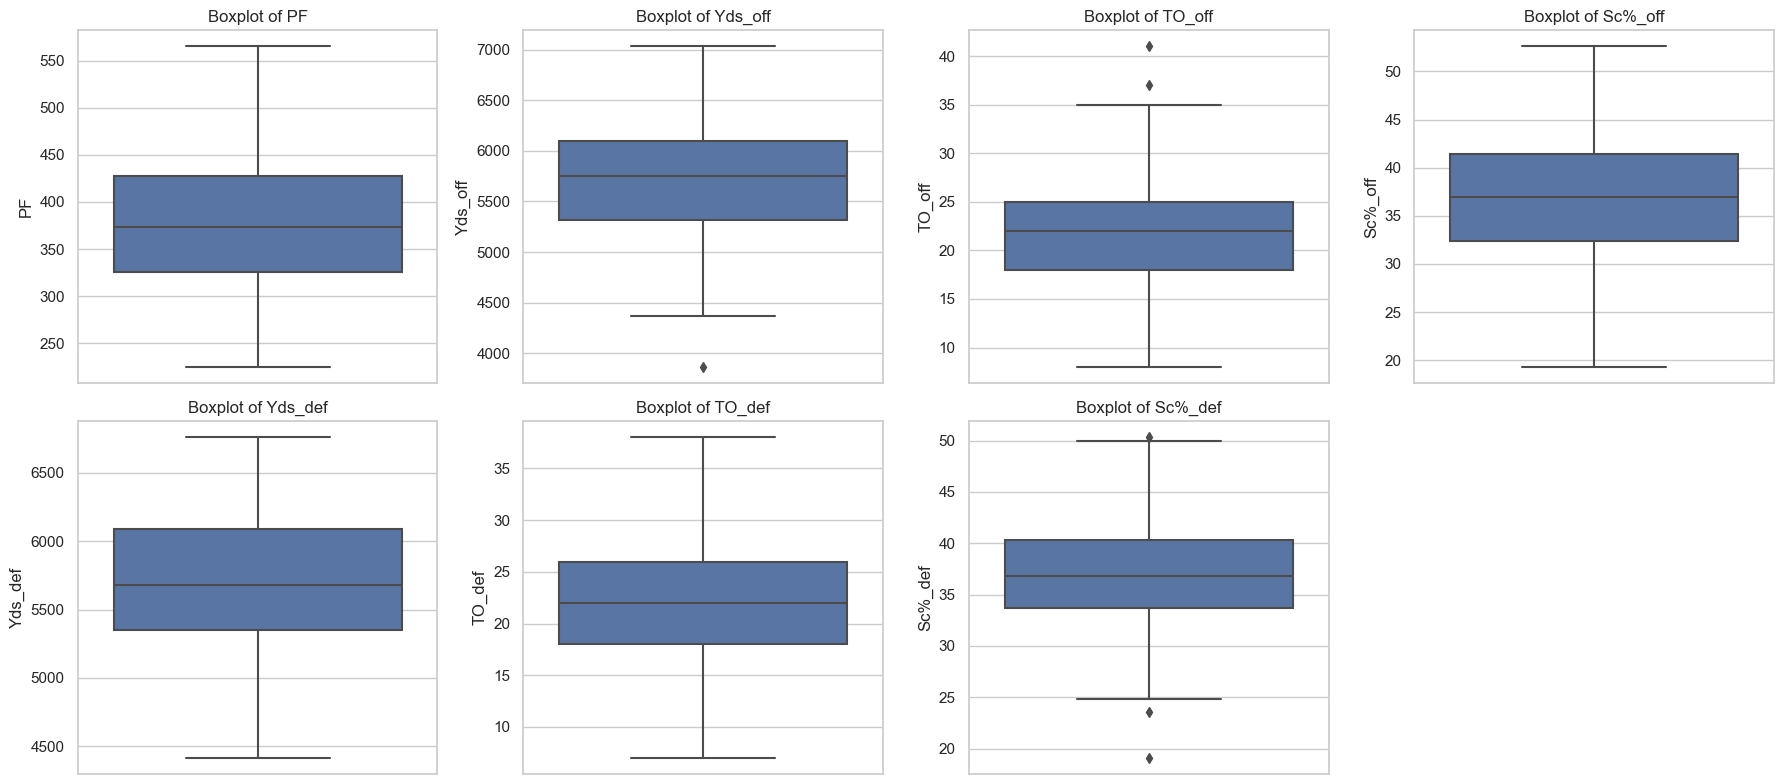

In [24]:
plt.figure(figsize=(18, 8))
for i, column in enumerate(columns_to_plot[:-1]):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(y=final_df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

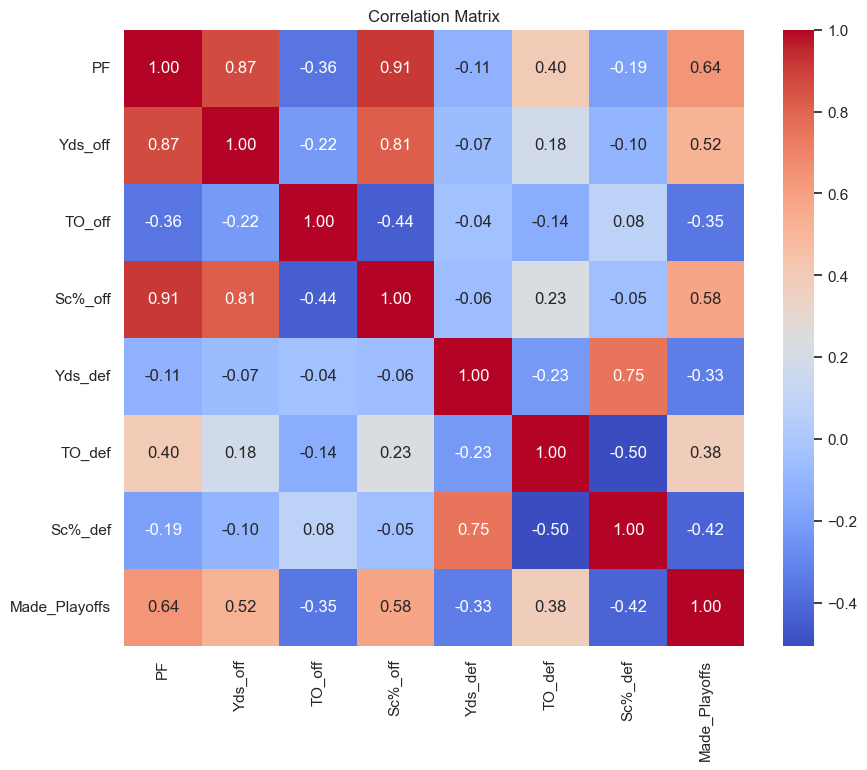

In [25]:
correlation_matrix = final_df[columns_to_plot].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering/Feature Selection

In [26]:
# Points Per Play (PPP)
final_df['PPP_off'] = final_df['PF'] / final_df['Ply_off']
final_df['PPP_def'] = final_df['PA'] / final_df['Ply_def']

# Yards Per Point (YPP)
final_df['YPP_off'] = final_df['Yds_off'] / final_df['PF']
final_df['YPP_def'] = final_df['Yds_def'] / final_df['PA']

# Offense to Defense Yard Ratio (ODYR)
final_df['ODYR'] = final_df['Yds_off'] / final_df['Yds_def']

In [27]:
final_df['TO_per_game_def'] = final_df['TO_def'] / final_df['G_def']

In [28]:
X = final_df.drop(['Tm', 'Made_Playoffs'], axis=1)
y = final_df['Made_Playoffs']
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X, y, test_size=0.3, random_state=42)

rf_updated = RandomForestClassifier(n_estimators=100, random_state=42)
rf_updated.fit(X_train_updated, y_train_updated)
feature_importances_updated = rf_updated.feature_importances_
feature_names_updated = X.columns
feature_importance_updated_df = pd.DataFrame({'Feature': feature_names_updated, 'Importance': feature_importances_updated})
feature_importance_updated_df = feature_importance_updated_df.sort_values(by='Importance', ascending=False)

selected_features = feature_importance_updated_df.head(25)

In [30]:
features = selected_features['Feature'].tolist()

In [31]:
features

['Rk_off',
 'ODYR',
 '1stD_off',
 'PF',
 'YPP_off',
 'EXP_off',
 'Sc%_off',
 'Att.1_def',
 'PPP_def',
 'Yds_off',
 'PPP_off',
 'PA',
 'Y/P_def',
 'Int_off',
 'YPP_def',
 'Yds.2_def',
 '1stD.2_def',
 'TO%_off',
 'Rk_def',
 'TD_off',
 'Sc%_def',
 'Yds.1_off',
 'NY/A_def',
 'Y/P_off',
 '1stD_def']

## Preparing Data for Neural Network

In [32]:
X = final_df[features]
y = final_df['Made_Playoffs']

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Building Initial Model

In [153]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1], kernel_regularizer=l1(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                1664      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3777 (14.75 KB)
Trainable params: 3777 (14.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [155]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
5/5 [==============================] - 3s 98ms/step - loss: 5.4405 - accuracy: 0.5000 - val_loss: 5.2947 - val_accuracy: 0.4483
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 5.2967 - accuracy: 0.5522 - val_loss: 5.1406 - val_accuracy: 0.6207
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 5.0947 - accuracy: 0.6866 - val_loss: 4.9992 - val_accuracy: 0.6207
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 5.0102 - accuracy: 0.7388 - val_loss: 4.8653 - val_accuracy: 0.7931
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 4.8810 - accuracy: 0.6642 - val_loss: 4.7349 - val_accuracy: 0.8621
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 4.7453 - accuracy: 0.7164 - val_loss: 4.6117 - val_accuracy: 0.8621
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 4.6477 - accuracy: 0.7313 - val_loss: 4.4951 - val_accuracy: 0.8621
Epoch 8/100
5/5 [===

In [156]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 0s 68ms/step - loss: 0.6070 - accuracy: 0.8621
Test Loss: 0.6069961786270142
Test Accuracy: 0.8620689511299133


## Hyperparameter Tuning for Initial Model

In [157]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
)

tuner.search(
    x=X_train_scaled, 
    y=y_train,
    epochs=100,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.8965517282485962

Best val_accuracy So Far: 0.9482758641242981
Total elapsed time: 00h 06m 00s


In [158]:
best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 376ms/step - loss: 0.4864 - accuracy: 0.8276
Test Loss: 0.4863949418067932
Test Accuracy: 0.8275862336158752


In [159]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 64,
 'dropout': 0.30000000000000004,
 'units2': 64,
 'dropout2': 0.4,
 'learning_rate': 0.0004264401157975197}

## Retraining Model with Optimal Hyperparameters

In [160]:
X_full_train_scaled = np.vstack((X_train_scaled, X_val_scaled))
y_full_train = np.concatenate([y_train, y_val])

In [161]:
final_model = Sequential([
    Dense(units=best_hps.get('units'), activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(best_hps.get('dropout')),
    Dense(units=best_hps.get('units2'), activation='relu'),
    Dropout(best_hps.get('dropout2')),
    Dense(1, activation='sigmoid')
])

final_model.compile(optimizer=Adam(best_hps.get('learning_rate')), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


history = final_model.fit(X_full_train_scaled, y_full_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 3s 4ms/step - loss: 0.7710 - accuracy: 0.5644
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6066 - accuracy: 0.6810
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5685 - accuracy: 0.6871
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5581 - accuracy: 0.6933
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.4726 - accuracy: 0.8037
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4724 - accuracy: 0.7853
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4219 - accuracy: 0.8282
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4161 - accuracy: 0.8098
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4148 - accuracy: 0.8037
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3986 - accuracy: 0.8221
Epoch 11/100
6/6 [========

In [162]:
final_loss, final_accuracy = final_model.evaluate(X_test_scaled, y_test)
print(f"Final Test Loss: {final_loss}")
print(f"Final Test Accuracy: {final_accuracy}")

1/1 [==============================] - 0s 219ms/step - loss: 0.2895 - accuracy: 0.9310
Final Test Loss: 0.28954505920410156
Final Test Accuracy: 0.931034505367279


## Simpler Model Approach with Learning Rate Scheduling

In [114]:
def build_model_simple(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    activation='relu',
                    input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model_simple,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    overwrite=True
)

tuner.search(
    x=X_train_scaled, 
    y=y_train,
    epochs=100,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Trial 20 Complete [00h 00m 17s]
val_accuracy: 0.8793103694915771

Best val_accuracy So Far: 0.9482758641242981
Total elapsed time: 00h 05m 57s


In [115]:
best_hps_simple = tuner.get_best_hyperparameters(num_trials=1)[0]

print("The best hyperparameters are:")
print(f" - Number of units in the first dense layer: {best_hps_simple.get('units')}")
print(f" - Dropout rate: {best_hps_simple.get('dropout')}")
print(f" - Learning rate: {best_hps_simple.get('learning_rate')}")

The best hyperparameters are:
 - Number of units in the first dense layer: 128
 - Dropout rate: 0.30000000000000004
 - Learning rate: 0.0029925267975241636


In [116]:
early_stopping_final = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [118]:
final_model_simple = Sequential([
    Dense(units=best_hps_simple.get('units'), activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(best_hps_simple.get('dropout')),
    Dense(1, activation='sigmoid')
])

initial_learning_rate = best_hps_simple.get('learning_rate')
final_model_simple.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

def scheduler(epoch, lr):
    if epoch < 5:
        return lr  
    else:
        return lr * 0.95 

lr_scheduler = LearningRateScheduler(scheduler)

history = final_model_simple.fit(X_full_train_scaled, y_full_train,
                          epochs=100,
                          batch_size=32,
                          callbacks=[early_stopping_final, lr_scheduler])

Epoch 1/100
6/6 [==============================] - 1s 10ms/step - loss: 0.5516 - accuracy: 0.7178 - lr: 0.0030
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3596 - accuracy: 0.8282 - lr: 0.0030
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3152 - accuracy: 0.8528 - lr: 0.0030
Epoch 4/100
6/6 [==============================] - 0s 17ms/step - loss: 0.3000 - accuracy: 0.8712 - lr: 0.0030
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.2937 - accuracy: 0.8650 - lr: 0.0030
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2888 - accuracy: 0.8589 - lr: 0.0028
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2813 - accuracy: 0.8834 - lr: 0.0027
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2727 - accuracy: 0.8712 - lr: 0.0026
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2777 - accuracy: 0.8466 - lr: 0.0024
Epoch 1

In [120]:
new_final_loss, new_final_accuracy = final_model_simple.evaluate(X_test_scaled, y_test)
print("Simple Model Test Loss:", new_final_loss)
print("Simple Model Test Accuracy:", new_final_accuracy)

1/1 [==============================] - 0s 111ms/step - loss: 0.3272 - accuracy: 0.9310
Simple Model Test Loss: 0.3272389769554138
Simple Model Test Accuracy: 0.931034505367279


## Attempting a More Complex Model with LR Scheduling

In [121]:
def build_model_v3(hp):
    model = Sequential()

    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model_v3,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    overwrite=True
)

tuner.search(
    x=X_train_scaled, 
    y=y_train,
    epochs=100,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)


Trial 20 Complete [00h 00m 13s]
val_accuracy: 0.9137931168079376

Best val_accuracy So Far: 0.931034505367279
Total elapsed time: 00h 04m 02s


In [122]:
best_hps_v3 = tuner.get_best_hyperparameters(num_trials=1)[0]

In [123]:
final_model_v3 = Sequential()

final_model_v3.add(Dense(units=best_hps_v3.get('units1'), activation='relu', input_shape=(X_train_scaled.shape[1],)))
final_model_v3.add(BatchNormalization())
final_model_v3.add(Dropout(rate=best_hps_v3.get('dropout1')))

final_model_v3.add(Dense(units=best_hps_v3.get('units2'), activation='relu'))
final_model_v3.add(BatchNormalization())
final_model_v3.add(Dropout(rate=best_hps_v3.get('dropout2')))
final_model_v3.add(Dense(units=1, activation='sigmoid'))

final_model_v3.compile(optimizer=Adam(learning_rate=best_hps_v3.get('learning_rate')),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

early_stopping_final = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr  
    else:
        return lr * 0.95  

lr_scheduler = LearningRateScheduler(scheduler)

history = final_model_v3.fit(X_full_train_scaled, y_full_train,
                          epochs=100,
                          batch_size=32,
                          callbacks=[early_stopping_final, lr_scheduler])

Epoch 1/100
6/6 [==============================] - 3s 6ms/step - loss: 0.8151 - accuracy: 0.6258 - lr: 6.1291e-04
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8031 - accuracy: 0.6012 - lr: 6.1291e-04
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.7440 - accuracy: 0.6626 - lr: 6.1291e-04
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.7124 - accuracy: 0.6871 - lr: 6.1291e-04
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.7767 - accuracy: 0.6687 - lr: 6.1291e-04
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5842 - accuracy: 0.7178 - lr: 5.8226e-04
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5658 - accuracy: 0.7791 - lr: 5.5315e-04
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5805 - accuracy: 0.7423 - lr: 5.2549e-04
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5198 - accu

In [125]:
complex_final_loss, complex_final_accuracy = final_model_v3.evaluate(X_test_scaled, y_test)
print("Complex Model Test Loss with LR Scheduling:", complex_final_loss)
print("Complex Model Test Accuracy with LR Scheduling:", complex_final_accuracy)

1/1 [==============================] - 0s 74ms/step - loss: 0.3720 - accuracy: 0.8966
Complex Model Test Loss with LR Scheduling: 0.372007817029953
Complex Model Test Accuracy with LR Scheduling: 0.8965517282485962


## Adding L2 Regularization to Model

In [127]:
best_hps = {
    'units1': 64,
    'dropout1': 0.3,
    'units2': 16,
    'dropout2': 0.4,
    'learning_rate': 0.00415593577617341
}

final_model_reg = Sequential([
    Dense(units=best_hps['units1'], activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(best_hps['dropout1']),
    Dense(units=best_hps['units2'], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(best_hps['dropout2']),
    Dense(1, activation='sigmoid')
])

final_model_reg.compile(optimizer=Adam(learning_rate=best_hps['learning_rate']), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = final_model_reg.fit(X_full_train_scaled, y_full_train, 
                          epochs=100, 
                          batch_size=32, 
                          callbacks=[early_stopping])

final_loss_reg, final_accuracy_reg = final_model_reg.evaluate(X_test_scaled, y_test)
print(f"Final Test Loss: {final_loss_reg}")
print(f"Final Test Accuracy: {final_accuracy_reg}")

Epoch 1/100
6/6 [==============================] - 3s 6ms/step - loss: 1.1839 - accuracy: 0.6135
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 1.0061 - accuracy: 0.8098
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.9023 - accuracy: 0.8344
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8185 - accuracy: 0.8344
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7807 - accuracy: 0.8466
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.7411 - accuracy: 0.8405
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6893 - accuracy: 0.8466
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6297 - accuracy: 0.8589
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5799 - accuracy: 0.8834
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5933 - accuracy: 0.8650
Epoch 11/100
6/6 [========

In [128]:
def build_model_regularization(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    activation='relu',
                    input_shape=(X_train_scaled.shape[1],),
                    kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model_regularization,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    overwrite=True  
)

tuner.search(
    x=X_train_scaled, 
    y=y_train,
    epochs=100,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping_final]
)

Trial 20 Complete [00h 00m 14s]
val_accuracy: 0.9137931168079376

Best val_accuracy So Far: 0.9655172228813171
Total elapsed time: 00h 05m 11s


In [129]:
best_hps_reg = tuner.get_best_hyperparameters(num_trials=1)[0]

In [132]:
final_model_reg_lr = Sequential([
    Dense(units=best_hps_reg.get('units'), activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=l2(best_hps_reg.get('l2_reg'))),
    Dropout(best_hps_reg.get('dropout')),
    Dense(units=best_hps_reg.get('units2'), activation='relu', kernel_regularizer=l2(best_hps_reg.get('l2_reg'))),
    Dropout(best_hps_reg.get('dropout2')),
    Dense(1, activation='sigmoid')
])

initial_learning_rate = best_hps_reg.get('learning_rate')
final_model_reg_lr.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

def scheduler(epoch, lr):
    if epoch < 5:
        return lr  
    else:
        return lr * 0.95  
lr_scheduler = LearningRateScheduler(scheduler)

history = final_model_reg_lr.fit(X_full_train_scaled, y_full_train,
                             epochs=100,
                             batch_size=32,
                             callbacks=[early_stopping_final, lr_scheduler])

final_loss_reg_lr, final_accuracy_reg_lr = final_model_reg_lr.evaluate(X_test_scaled, y_test)
print(f"Final Test Loss: {final_loss_reg_lr}")
print(f"Final Test Accuracy: {final_accuracy_reg_lr}")

Epoch 1/100
6/6 [==============================] - 2s 4ms/step - loss: 0.7596 - accuracy: 0.5706
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5337 - accuracy: 0.8528
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4882 - accuracy: 0.8221
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4460 - accuracy: 0.8221
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4155 - accuracy: 0.8712
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3885 - accuracy: 0.8834
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3989 - accuracy: 0.8466
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3871 - accuracy: 0.8589
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3971 - accuracy: 0.8589
Epoch 10/100
6/6 [==============================] - 0s 21ms/step - loss: 0.3724 - accuracy: 0.8773
Epoch 11/100
6/6 [====

## Choosing a Final Model

In [177]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1664      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5889 (23.00 KB)
Trainable params: 5889 (23.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model that performed the best in terms of test loss and accuracy was the initial model with optimized hyperparameters. Two hidden layers with appropriate units of 64 and 64 provide a balance between complexity and performance. The hypothesis behind why this model performs the best is that the we found an optimal model that is not too complex for the smaller amount of data we are working with. The model is generalizing very well to new data without learning all of the noise of the training data, although in a perfect world we would want the test loss of this model to be even lower. Thanks to the help of two separate dropout layers and an optimal learning rate of 0.0004, the model excels at its ability to perform on unseen data and is the best model for predicting whether a team will make the NFL playoffs or not based on all the testing done above. 

In [164]:
print(f"Final Test Loss from Initial Hyperparameter Tuned Model: {final_loss}")
print(f"Final Test Accuracy Initial Hyperparameter Tuned Model: {final_accuracy}")

Final Test Loss from Initial Hyperparameter Tuned Model: 0.28954505920410156
Final Test Accuracy Initial Hyperparameter Tuned Model: 0.931034505367279


In [173]:
y_pred = (final_model.predict(X_test_scaled) > 0.5).astype(int)
y_pred_prob = final_model.predict(X_test_scaled)

1/1 [==============================] - 0s 27ms/step


In [174]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred, target_names=['Not Playoffs', 'Playoffs'])
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[13  1]
 [ 1 14]]

Classification Report:
              precision    recall  f1-score   support

Not Playoffs       0.93      0.93      0.93        14
    Playoffs       0.93      0.93      0.93        15

    accuracy                           0.93        29
   macro avg       0.93      0.93      0.93        29
weighted avg       0.93      0.93      0.93        29



In [176]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9333


## Appending Probabilities from our Chosen Model back to the NFL Data

In [165]:
X_final = final_df[features]  
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final) 

pred_probabilities = final_model.predict(X_final_scaled)
pred_df = final_df[['Tm', 'Year']].copy()
pred_df['playoff_probability'] = pred_probabilities

final_df_with_predictions = final_df.merge(pred_df[['Tm', 'Year', 'playoff_probability']], on=['Tm', 'Year'])

6/6 [==============================] - 0s 2ms/step


In [171]:
final_df_with_predictions.head()

,Rk_off,Tm,G_off,PF,Yds_off,Ply_off,Y/P_off,TO_off,FL_off,1stD_off,Cmp_off,Att_off,Yds.1_off,TD_off,Int_off,NY/A_off,1stD.1_off,Att.1_off,Yds.2_off,TD.1_off,Y/A_off,1stD.2_off,Pen_off,Yds.3_off,1stPy_off,Sc%_off,TO%_off,EXP_off,Year,Rk_def,G_def,PA,Yds_def,Ply_def,Y/P_def,TO_def,FL_def,1stD_def,Cmp_def,Att_def,Yds.1_def,TD_def,Int_def,NY/A_def,1stD.1_def,Att.1_def,Yds.2_def,TD.1_def,Y/A_def,1stD.2_def,Pen_def,Yds.3_def,1stPy_def,Sc%_def,TO%_def,EXP_def,Made_Playoffs,PPP_off,PPP_def,YPP_off,YPP_def,ODYR,TO_per_game_def,playoff_probability
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,372.0,526.0,4106.0,48.0,5.0,7.5,216.0,443.0,2118.0,16.0,4.8,114.0,84.0,684.0,28.0,49.7,5.6,290.75,2020,13.0,16.0,369.0,5344.0,974.0,5.5,18.0,7.0,332.0,346.0,536.0,3539.0,23.0,11.0,6.1,184.0,397.0,1805.0,16.0,4.5,119.0,79.0,734.0,29.0,39.9,11.4,-109.67,1.0,0.514141,0.378850,12.227898,14.482385,1.164671,1.1250,0.992865
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,410.0,596.0,4620.0,40.0,11.0,7.4,240.0,411.0,1723.0,16.0,4.2,119.0,102.0,941.0,38.0,49.4,11.8,228.66,2020,16.0,16.0,375.0,5640.0,1025.0,5.5,26.0,11.0,351.0,369.0,573.0,3726.0,23.0,15.0,6.1,199.0,414.0,1914.0,21.0,4.6,125.0,86.0,728.0,27.0,39.4,15.3,-123.10,1.0,0.484526,0.365854,12.660679,15.040000,1.124645,1.6250,0.961580
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,410.0,626.0,4626.0,42.0,12.0,7.1,238.0,369.0,1519.0,16.0,4.1,82.0,84.0,715.0,44.0,47.8,8.9,246.24,2020,8.0,16.0,355.0,5234.0,1023.0,5.1,25.0,10.0,319.0,426.0,617.0,3945.0,29.0,15.0,5.9,215.0,358.0,1289.0,10.0,3.6,78.0,95.0,1015.0,26.0,33.7,14.0,-22.04,1.0,0.483776,0.347019,12.489837,14.743662,1.174054,1.5625,0.991568
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,316.0,485.0,3653.0,33.0,7.0,7.2,203.0,521.0,2690.0,26.0,5.2,142.0,86.0,783.0,36.0,47.9,7.2,245.01,2020,24.0,16.0,439.0,6372.0,1076.0,5.9,23.0,8.0,391.0,423.0,630.0,4439.0,36.0,15.0,6.8,247.0,427.0,1933.0,18.0,4.5,113.0,103.0,840.0,31.0,45.2,13.3,-185.20,1.0,0.476237,0.407993,12.918534,14.514806,0.995449,1.4375,0.853681
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,370.0,522.0,3758.0,28.0,8.0,6.8,199.0,494.0,2265.0,30.0,4.6,147.0,98.0,1005.0,21.0,45.5,9.0,176.94,2020,5.0,16.0,337.0,4974.0,992.0,5.0,26.0,8.0,320.0,333.0,557.0,3472.0,28.0,18.0,5.8,185.0,390.0,1502.0,11.0,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,1.0,0.461244,0.339718,12.495851,14.759644,1.210897,1.6250,0.981638


In [181]:
year = 2018
top_teams = final_df_with_predictions[final_df_with_predictions['Year'] == year].sort_values(by='playoff_probability', ascending=False)

print(f'Top teams predicted to make playoffs in {year}:')
print(top_teams[['Tm', 'playoff_probability', 'Made_Playoffs']])

Top teams predicted to make playoffs in 2018:
                       Tm  playoff_probability  Made_Playoffs
162    New Orleans Saints             0.987518            1.0
161      Los Angeles Rams             0.968935            1.0
160    Kansas City Chiefs             0.960616            1.0
168         Chicago Bears             0.955011            1.0
166  Los Angeles Chargers             0.943255            1.0
163  New England Patriots             0.937401            1.0
172      Baltimore Ravens             0.927954            1.0
170        Houston Texans             0.922636            1.0
164    Indianapolis Colts             0.901556            1.0
165      Seattle Seahawks             0.895834            1.0
167   Pittsburgh Steelers             0.828224            0.0
177   Philadelphia Eagles             0.681805            1.0
181        Dallas Cowboys             0.661465            1.0
169       Atlanta Falcons             0.572580            0.0
178     Minnesota Viking

In [170]:
team_probabilities = final_df_with_predictions.groupby('Tm')['playoff_probability'].mean().reset_index()
team_probabilities = team_probabilities.sort_values(by='playoff_probability', ascending=False)

print(team_probabilities)

                          Tm  playoff_probability
15        Kansas City Chiefs             0.921300
2           Baltimore Ravens             0.794815
22        New Orleans Saints             0.752975
8             Dallas Cowboys             0.751241
3              Buffalo Bills             0.730392
11         Green Bay Packers             0.714319
28       San Francisco 49ers             0.678744
18          Los Angeles Rams             0.658338
29          Seattle Seahawks             0.615680
26       Philadelphia Eagles             0.614535
13        Indianapolis Colts             0.562835
21      New England Patriots             0.552649
30      Tampa Bay Buccaneers             0.502990
31          Tennessee Titans             0.463345
17      Los Angeles Chargers             0.427068
20         Minnesota Vikings             0.411447
27       Pittsburgh Steelers             0.386347
19            Miami Dolphins             0.377972
6         Cincinnati Bengals             0.348510
